In [0]:
from fastai.vision import *
import pydicom
%config IPCompleter.greedy=True

Download data from https://www.kaggle.com/seesee/siim-train-test

Put this into `data/245622-651264-bundle-archive.zip`

In [0]:
!unzip ../data/245622-651264-bundle-archive.zip -d ../data/

In [0]:
images_root_path = Path("../data/siim/dicom-images-train")
files = images_root_path.glob('**/*.dcm')
input_images = [path.relative_to("../data/siim/dicom-images-train") for path in files]

file_map = {path.stem : path for path in input_images}

In [0]:
def remap(value):
    if value == "-1":
        return "no"
    else:
        return "yes"

df = pd.read_csv('../data/siim/train-rle.csv', header='infer')
df["present"] = df[" EncodedPixels"].map(remap)
df["ImageId"] = df["ImageId"].map(lambda filename: file_map[filename])
df.head()

,ImageId,EncodedPixels,present
0,1.2.276.0.7230010.3.1.2.8323329.6904.151787520...,-1,no
1,1.2.276.0.7230010.3.1.2.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,yes
2,1.2.276.0.7230010.3.1.2.8323329.11028.15178752...,-1,no
3,1.2.276.0.7230010.3.1.2.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,yes
4,1.2.276.0.7230010.3.1.2.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,yes


In [0]:
def dcm_to_image(dcm_path, **kwargs):
    pixel_data = pydicom.dcmread(dcm_path).pixel_array
    image = PIL.Image.fromarray(pixel_data).convert('RGB')
    return Image(pil2tensor(image, np.float32).div_(255))

vision.data.open_image = dcm_to_image

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_df(Path('../data/siim/dicom-images-train'), df, valid_pct=0.2,
        label_col=2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

/Users/daniel/Development/fastai-sandbox/env/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


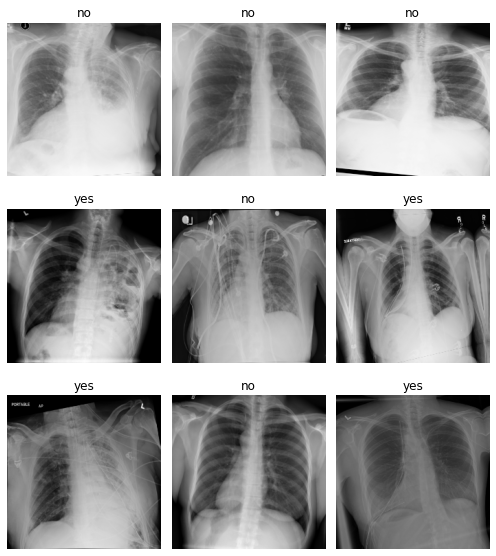

In [0]:
data.show_batch(rows=3, figsize=(7, 8))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/daniel/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time


Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [0]:
learn.save('stage-1', return_path=True)